# Q1

Github url:
https://github.com/HYuLeeP/ASTR4004_A3

#### working branch: develop

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Q2
### Using ADQL to Search for Bright Stars Around the Open Cluster M67



In [2]:
### 2.1 GAIA query
from astroquery.gaia import Gaia

In [3]:
# Define and execute the ADQL query to crossmatch with Gaia DR3
query = f"""
SELECT *
FROM gaiadr3.gaia_source as gaia
JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
JOIN gaiadr1.tmass_original_valid AS tmass
ON tmass.designation = xmatch.original_ext_source_id 

WHERE DISTANCE(132.825,11.8,gaia.ra,gaia.dec) < 1.
AND gaia.phot_g_mean_mag < 14.
"""

# Upload the source_id table for crossmatching
job = Gaia.launch_job_async(query=query)
gaiadr3_match = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [4]:
display(gaiadr3_match)
data=np.array(gaiadr3_match) # convert to numpy structured array

solution_id,DESIGNATION,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,original_ext_source_id,angular_distance,xm_flag,clean_tmass_psc_xsc_oid,number_of_neighbours,number_of_mates,SOURCE_ID,ph_qual,tmass_oid,designation,ra_2,dec_2,err_maj,err_min,err_ang,j_m,j_msigcom,h_m,h_msigcom,ks_m,ks_msigcom,ext_key,j_date
,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,,,,,,,d,km / s,K,log(cm.s**-2),dex,,km / s,km / s,,mag,mag,,,,deg,deg,deg,deg,,,,,,,,,,,,,,,K,K,K,log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),dex,dex,dex,pc,pc,pc,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,arcsec,,,,,,,,,deg,deg,arcsec,arcsec,deg,mag,mag,mag,mag,mag,mag,,d
int64,object,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float3

In [5]:
len(data.dtype.names)

174

In [6]:
print(f"There are {len(data):,d} stars returned.")

There are 1,018 stars returned.


In [7]:
cdt=data['ph_qual'] != "AAA"
bad_2mass_photo=data[cdt]
print(f"There are {len(bad_2mass_photo):,d} stars with bad 2mass photometry.")

There are 21 stars with bad 2mass photometry.


In [8]:
cdt= ~(data['parallax'] > 0)
non_positive_pi=data[cdt]
print(f"There are {len(non_positive_pi):,d} stars with non-positive parallaxes.")

There are 9 stars with non-positive parallaxes.


In [9]:
cdt = ~(data['ph_qual'] != "AAA") & (data['parallax'] > 0) # note that there are 7 stars with nan parallaxes 
data=data[cdt]
print(f"There are {len(data):,d} stars with good quality.")

There are 988 stars with good quality.


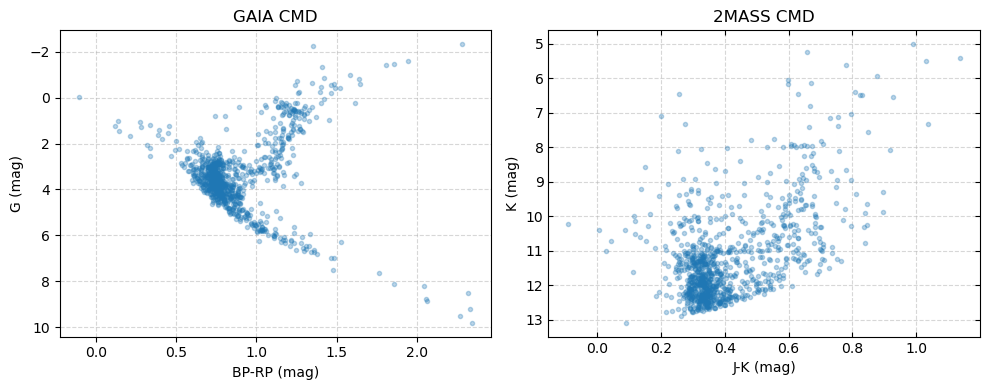

In [10]:
fig, axs = plt.subplots(1,2,figsize=(10,4))

d=1/data['parallax']*1000 #distance (pc)
G_abs=data['phot_g_mean_mag']-5*(np.log10(d)-1) #convert apparent to abs

# Plotting GAIA colour-mag diagram
ax=axs[0]
X=data['bp_rp']
Y=G_abs
ax.plot(X,Y,'.',alpha=.3)

ax.grid(linestyle="--",alpha=.5)
plt.gca().tick_params(top=True,bottom=True,
               left=True,right=True,
            #    labeltop=True,labelbottom=False,
               direction="in")
ax.invert_yaxis()

# do labeling
ax.set_xlabel(f"BP-RP (mag)")
ax.set_ylabel(f"G (mag)")
ax.set_title(f"GAIA CMD")

# Plotting 2MASS colour-mag diagram
ax=axs[1]
X=data['j_m']-data['ks_m'] # J-Ks
Y=data['ks_m']
ax.plot(X,Y,'.',alpha=.3)

plt.grid(linestyle="--",alpha=.5)
plt.gca().tick_params(top=True,bottom=True,
               left=True,right=True,
            #    labeltop=True,labelbottom=False,
               direction="in")
ax.invert_yaxis()

# do labeling
ax.set_xlabel(f"J-K (mag)")
ax.set_ylabel(f"K (mag)")
ax.set_title(f"2MASS CMD")

plt.tight_layout()
plt.savefig("./figures/cmds M67.png",dpi=200,bbox_inches="tight")

#### Comments:
As there are 392 fibres on the 2dF Instrument and takes about 45 minutes to complete each observation, the current number of good stars (~1000) takes only about 2.5hrs to finish. 

> Based upon historical weather trends, about 33% of time is lost to bad weather. Proposers are therefore required to multiply their time requirement by a factor of 1.5 to allow for time lost to weather.

Then about 4 to 5 hrs should be proposed for the observation.

In [11]:
import astropy.io.fits as ft
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
from matplotlib.gridspec import GridSpec

# Q3
### The radial metallicity relation in simulated data 

In [12]:
# read data
filename='./data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits'

data_ft=ft.open(filename)

data=data_ft[1].data
data_ft.close()

In [13]:
len(data)

511520

In [14]:
Rgal=np.sqrt(data['x']**2+data['y']**2)

The linear fit gives y = -0.03x+9.13
where
k = -0.03420 +- 0.000015
b = 9.1278 +- 0.00023


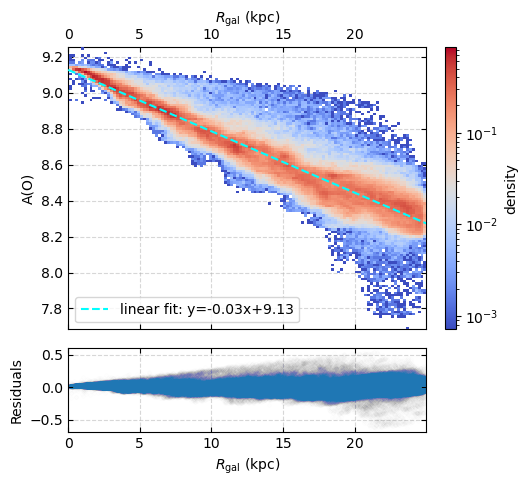

In [15]:
# Linear fit
X=Rgal
Y=data['A_O']
coeff, cov=np.polyfit(X, Y, 1,cov=True)
k, b = coeff  # slope and intercept
ek,eb = np.sqrt(np.diag(cov))
print(f"The linear fit gives y = {k:.2f}x+{b:.2f}\nwhere\nk = {k:.5f} +- {ek:.6f}\nb = {b:.4f} +- {eb:.5f}")

fig = plt.figure(figsize=(5,5))
gs = GridSpec(2,2, 
              height_ratios=[1,.3],
              width_ratios=[1,.03],
              wspace=.1,hspace=.1)

axs=[]
axs.append(fig.add_subplot(gs[0,0]))
axs.append(fig.add_subplot(gs[0,1]))
axs.append(fig.add_subplot(gs[1,0]))

# Plotting log density of Rgal-A(O)
ax=axs[0]
X=Rgal
Y=data['A_O']
hist,_,_,im=ax.hist2d(X,Y,cmap="coolwarm",
                      norm=cl.LogNorm(),
                      density=True,
                      zorder=10,
                      bins=120,
                    #   label="data",
                      )

ax.grid(linestyle="--",alpha=.5)

# do labeling
ax.set_xlabel(r"$R_{\mathrm{gal}}$ (kpc)")
ax.set_ylabel(r"A(O)")
ax.xaxis.set_label_position('top') 
ax.tick_params(top=True,bottom=True,
               left=True,right=True,
               labeltop=True,labelbottom=False,
               direction="in")
ax.set_xlim(0,max(Rgal))

# plot the fit
X=np.linspace(0,max(Rgal),10)
Y=k*X+b
ax.plot(X,Y,'--',label=f"linear fit: y={k:.2f}x+{b:.2f}",zorder=20,color="cyan")
ax.legend(loc="lower left")

# plot colorbar
ax=axs[1]
fig.colorbar(mappable=im,cax=ax,label="density")

# plot the residual
ax=axs[2]
model_y=k*Rgal+b
X=Rgal
Y=data['A_O']-model_y # residual
ax.plot(X,Y,'.',alpha=.002)
ax.grid(linestyle="--",alpha=.5)

# do labeling
ax.set_xlabel(r"$R_{\mathrm{gal}}$ (kpc)")
ax.set_ylabel("Residuals")
ax.tick_params(top=True,bottom=True,
               left=True,right=True,
            #    labeltop=True,labelbottom=False,
               direction="in")
ax.set_xlim(0,max(Rgal))
plt.savefig("./figures/metal_gradient.png",dpi=200,bbox_inches="tight")
plt.show()


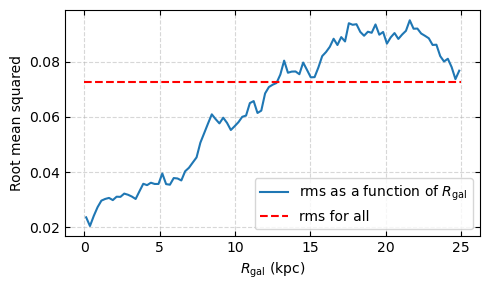

In [16]:
# Generate bins in Rgal
nbin=100
binedges=np.linspace(0,max(Rgal),nbin)
bincentre=(binedges[:-1]+binedges[1:])/2

# define root means squared metric
def root_mean_squred(data,predict):
    return np.sqrt(((predict - data) ** 2).mean())

# obtain rms(Rgal)
binrms=[]
for i in range(nbin-1):
    bin=[binedges[i],binedges[i+1]]

    cdt= (Rgal>bin[0]) & (Rgal < bin[1])
    binrms.append(root_mean_squred(data['A_O'][cdt],model_y[cdt]))

# plot figure
plt.figure(figsize=(5,3))
plt.plot(bincentre,binrms,'-',label=r"rms as a function of $R_{\mathrm{gal}}$")
plt.xlabel(r"$R_{\mathrm{gal}}$ (kpc)")
plt.ylabel("Root mean squared")

plt.grid(linestyle="--",alpha=.5)
plt.gca().tick_params(top=True,bottom=True,
               left=True,right=True,
            #    labeltop=True,labelbottom=False,
               direction="in")

# plot the rms for all stars
rms=root_mean_squred(data['A_O'],model_y)
plt.plot([0,max(Rgal)],[rms,rms],'r--',label=r"rms for all")
plt.legend()

plt.tight_layout()
plt.savefig("./figures/rms.png",dpi=200,bbox_inches="tight")

#### Comment

The linear approximation of the gas phase metallicity as a function of galactic radius works well in the inner galaxy, where $R_{\mathrm{gal}} \lesssim 7$ kpc. The root mean squared error rises significantly towards larger galactic radii, which peaks at about $R_{\mathrm{gal}} \sim 20$ kpc.

This can be understood by the increase in the dispersion in A(O) at larger radii in both the main population (red population in the metal_gradient plot) and the increasing number and difference in outliers (blue population in the metal_gradient plot).

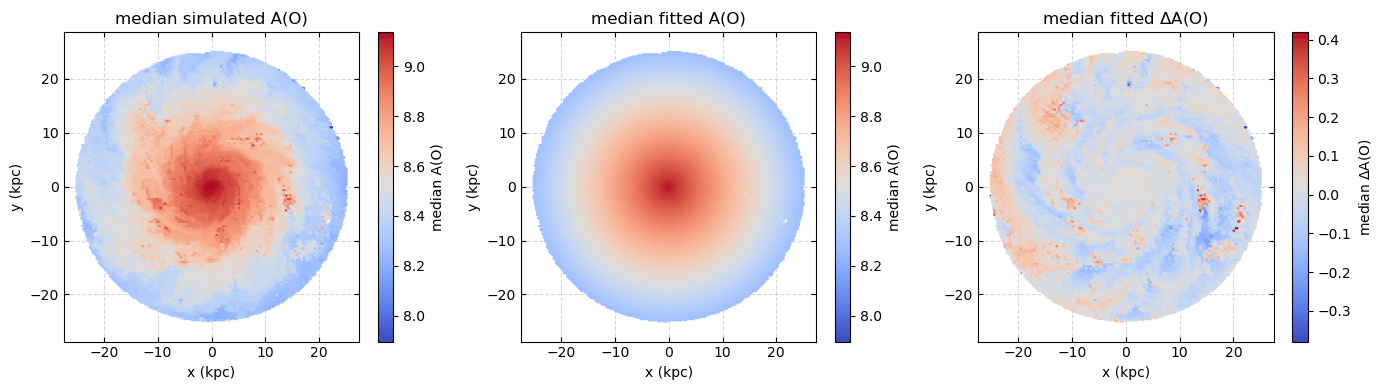

In [17]:
fig, axs = plt.subplots(1,3,figsize=(14,4))

# 2D-histogram of the median simulated A(O)
ax=axs[0]

X=data['x']
Y=data['y']
Z=data['A_O']
Nbin=120 #set the 2D bins
range=(min(X),max(X),min(Y),max(Y))
im=ax.hexbin(X,Y,Z,gridsize=(Nbin,Nbin),
          extent=range,
          reduce_C_function=np.median, #median of simulated data
          cmap="coolwarm",
          norm=cl.Normalize(),
          zorder=10,
          )
# labelling
ax.axis('equal')
ax.set_xlabel('x (kpc)')
ax.set_ylabel('y (kpc)')
fig.colorbar(im,ax=ax,label='median A(O)')
ax.grid(linestyle="--",alpha=.5)
ax.tick_params(top=True,bottom=True,
               left=True,right=True,
            #    labeltop=True,labelbottom=False,
               direction="in")
ax.set_title("median simulated A(O)")

# get the values so we have the same vmin/vmax for the next plot
counts = im.get_array()
vmin=np.min(counts)
vmax=np.max(counts)

#######################################
# 2D-histogram of the mean fitted A(O)
ax=axs[1]

X=data['x']
Y=data['y']
Z=model_y

im=ax.hexbin(X,Y,Z,gridsize=(Nbin,Nbin),
          extent=range,
          reduce_C_function=np.median, #median of simulated data
          cmap="coolwarm",
          norm=cl.Normalize(vmin,vmax),
          zorder=10,
          )

# labelling
ax.axis('equal')
ax.set_xlabel('x (kpc)')
ax.set_ylabel('y (kpc)')
fig.colorbar(im,ax=ax,label='median A(O)')
ax.grid(linestyle="--",alpha=.5)
ax.tick_params(top=True,bottom=True,
               left=True,right=True,
            #    labeltop=True,labelbottom=False,
               direction="in")
ax.set_title("median fitted A(O)")

#######################################
# 2D-histogram of the median residuals ∆A(O).
ax=axs[2]

X=data['x']
Y=data['y']
Z=data['A_O']-model_y #residual
im=ax.hexbin(X,Y,Z,gridsize=(Nbin,Nbin),
          extent=range,
          reduce_C_function=np.median, #median of simulated data
          cmap="coolwarm",
          norm=cl.Normalize(),
          zorder=10,
          )

# labelling
ax.axis('equal')
ax.set_xlabel('x (kpc)')
ax.set_ylabel('y (kpc)')
fig.colorbar(im,ax=ax,label=r'median $\Delta$A(O)')
ax.grid(linestyle="--",alpha=.5)
ax.tick_params(top=True,bottom=True,
               left=True,right=True,
            #    labeltop=True,labelbottom=False,
               direction="in")
ax.set_title(r"median fitted $\Delta$A(O)")

plt.tight_layout()
plt.savefig("./figures/2dhistograms.png",dpi=200,bbox_inches="tight")

#### Dicussion

The number of bins is set to be $120\times120$. With this gridsize, the fine details of the spirals can be visible. With lower bin numbers (e.g $40\times40$ bins), the some details of the spirals, especially those at larger $R_{\mathrm{gal}}$, would be missing. With higher bin numbers (e.g $1000\times1000$ bins), the non-uniformly distributed data creates much more bins in which no data can be used to process. Both of these improper choices of bin number can give inaccurate bias in analysis.   

#### Analysis

As a Milky Way analogue, the simulated spiral galaxy have spiral patterns shown in the distribution of A(O). These non-axisymmetric patterns are not independent of the azimuthal angular position $\phi$. However, our linear fitting model approximated the gas phase metallicity only as a function of $R_{\mathrm{gal}}$, resulting in an axisymmetric approximation of the metallicity distribution. As a result, the spirals at larger galactic radii result in a larger residual at higher $R_{\mathrm{gal}}$. At $R_{\mathrm{gal}} \gtrsim 20$, the spirals dissolve into the uniform outer disk and thus shows a decrease in root mean squared error. At lower $R_{\mathrm{gal}}$, the central bulge shows a more axisymmetric distribution of metallicity, resulting in a better axisymmetric linear approximation.